# 8 Pilares Estadisticos: Evaluacion de Deuda Externa

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua el procesamiento de Deuda Externa realizado por `ETL_Principales.py`, aplicando los 8 pilares estadisticos fundamentales:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('..').resolve()
DATOS_ORIGEN = BASE_DIR / 'Datos_Origen/DatosPrincipales/DeudaPublica'
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'

print(f"Directorio base: {BASE_DIR}")
print(f"Datos origen: {DATOS_ORIGEN}")
print(f"Datos resultado: {DATOS_RESULTADO}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final
Datos origen: C:\Users\ARTUROJF\Desktop\Final\Datos_Origen\DatosPrincipales\DeudaPublica
Datos resultado: C:\Users\ARTUROJF\Desktop\Final\Datos_Resultado


## Carga de Datos

Cargamos tanto los datos **sin procesar** (originales) como los **procesados** por ETL_Principales.py

In [2]:
# ============================================================================
# CARGAR DATOS SIN PROCESAR (ORIGINALES)
# ============================================================================

def normalizar_texto(s):
    """Normaliza texto para comparaciones."""
    if pd.isna(s):
        return ""
    import unicodedata
    s = str(s).lower().strip()
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Cargar archivos historicos y actuales
path_hist = DATOS_ORIGEN / 'Historica/deuda_publica_hist.csv'
path_act = DATOS_ORIGEN / 'Actual/deuda_publica.csv'

df_hist = pd.read_csv(path_hist, encoding='latin1') if path_hist.exists() else pd.DataFrame()
df_act = pd.read_csv(path_act, encoding='utf-8') if path_act.exists() else pd.DataFrame()

# Concatenar
df_raw = pd.concat([df_hist, df_act], ignore_index=True, sort=False)

# Filtrar solo deuda externa
mask_ext = df_raw['SUBTEMA'].fillna('').apply(lambda x: 'deuda externa' in normalizar_texto(x))
df_deuda_externa_raw = df_raw[mask_ext].copy()

print(f"Registros historicos: {len(df_hist):,}")
print(f"Registros actuales: {len(df_act):,}")
print(f"Total registros: {len(df_raw):,}")
print(f"Registros Deuda Externa: {len(df_deuda_externa_raw):,}")
print(f"\nColumnas disponibles:")
print(df_deuda_externa_raw.columns.tolist())

Registros historicos: 62,975
Registros actuales: 81,442
Total registros: 144,417
Registros Deuda Externa: 80,578

Columnas disponibles:
['CICLO', 'MES', 'CLAVE_DE_CONCEPTO', 'NOMBRE', 'TEMA', 'SUBTEMA', 'SECTOR', 'AMBITO', 'TIPO_DE_INFORMACION', 'BASE_DE_REGISTRO', 'UNIDAD_DE_MEDIDA', 'PERIODO_INICIO', 'PERIODO_FINAL', 'FRECUENCIA', 'DIFUSION', 'MONTO']


In [3]:
# ============================================================================
# CARGAR DATOS PROCESADOS POR ETL_Principales.py
# ============================================================================

path_procesado = DATOS_RESULTADO / 'mexico_deuda_externa_core_mUSD.csv'
df_procesado = pd.read_csv(path_procesado) if path_procesado.exists() else pd.DataFrame()

print(f"\nDatos procesados: {len(df_procesado)} filas x {len(df_procesado.columns)} columnas")
print(f"\nColumnas procesadas:")
print(df_procesado.columns.tolist())
print(f"\nPrimeras filas:")
df_procesado.head()


Datos procesados: 143 filas x 29 columnas

Columnas procesadas:
['periodo', 'CICLO', 'TRIMESTRE', 'deuda_total_economia_musd', 'deuda_bruta_publica_musd', 'activos_fx_publico_musd', 'posicion_neta_publico_musd', 'deuda_publica_lp_musd', 'deuda_publica_cp_musd', 'deuda_gob_federal_musd', 'deuda_organismos_empresas_musd', 'deuda_banca_desarrollo_musd', 'endeudamiento_neto_total_musd', 'endeudamiento_neto_lp_musd', 'endeudamiento_neto_cp_musd', 'endeudamiento_neto_gf_musd', 'endeudamiento_neto_oye_musd', 'endeudamiento_neto_bd_musd', 'fuente_bancario_musd', 'fuente_comercio_ext_musd', 'fuente_capitales_musd', 'fuente_ofis_musd', 'fuente_pidiregas_musd', 'acreedor_eeuu_musd', 'acreedor_ofis_musd', 'acreedor_japon_musd', 'acreedor_otros_musd', 'moneda_usd_musd', 'moneda_canasta_musd']

Primeras filas:


,periodo,CICLO,TRIMESTRE,deuda_total_economia_musd,deuda_bruta_publica_musd,activos_fx_publico_musd,posicion_neta_publico_musd,deuda_publica_lp_musd,deuda_publica_cp_musd,deuda_gob_federal_musd,...,fuente_comercio_ext_musd,fuente_capitales_musd,fuente_ofis_musd,fuente_pidiregas_musd,acreedor_eeuu_musd,acreedor_ofis_musd,acreedor_japon_musd,acreedor_otros_musd,moneda_usd_musd,moneda_canasta_musd
0,1990-01-01,1990,1,94188.7,73527.3,0.0,73527.0,72792.1,735.2,42209.8,...,28170.8,10230.4,38046.0,0.0,19096.3,8949.9,12978.6,10986.0,45534.3,8949.9
1,1990-04-01,1990,2,97005.0,74478.8,0.0,74479.0,73616.8,862.0,42768.4,...,31108.7,10321.4,40175.7,0.0,17104.1,7810.9,14766.8,9607.4,46855.2,7810.9
2,1990-07-01,1990,3,102141.9,77457.7,6371.4,71086.0,76336.1,1121.6,60751.8,...,35036.5,11331.4,40989.0,0.0,18026.6,14024.3,13410.4,8137.2,44949.5,14024.3
3,1990-10-01,1990,4,106073.6,77770.3,5524.0,72246.3,76614.3,1156.0,60283.6,...,36853.1,11368.1,43691.3,0.0,20116.3,12756.6,13633.3,8110.6,51774.3,12756.6
4,1991-01-01,1991,1,104372.2,76669.2,7987.0,68683.0,75622.6,1046.6,59767.8,...,37248.5,12021.2,43373.4,0.0,17901.7,14246.8,13682.9,7577.4,49311.2,14246.8


In [4]:
# Preparar datos para analisis
df_procesado['periodo'] = pd.to_datetime(df_procesado['periodo'])
df_procesado = df_procesado.sort_values('periodo').reset_index(drop=True)

# Variables numericas principales
cols_numericas = [c for c in df_procesado.columns if c not in ['periodo', 'CICLO', 'TRIMESTRE']]
print(f"Variables numericas para analisis: {len(cols_numericas)}")

# Variable principal: deuda bruta publica
VAR_PRINCIPAL = 'deuda_bruta_publica_musd'
print(f"\nVariable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df_procesado[VAR_PRINCIPAL].min():.2f} - {df_procesado[VAR_PRINCIPAL].max():.2f} millones USD")

Variables numericas para analisis: 26

Variable principal: deuda_bruta_publica_musd
Rango: 54766.30 - 243107.90 millones USD


---
## PILAR 1: Distribuciones - ¿Que forma tienen los datos?

**Objetivo:** Identificar si los datos siguen una distribucion normal o requieren transformacion.

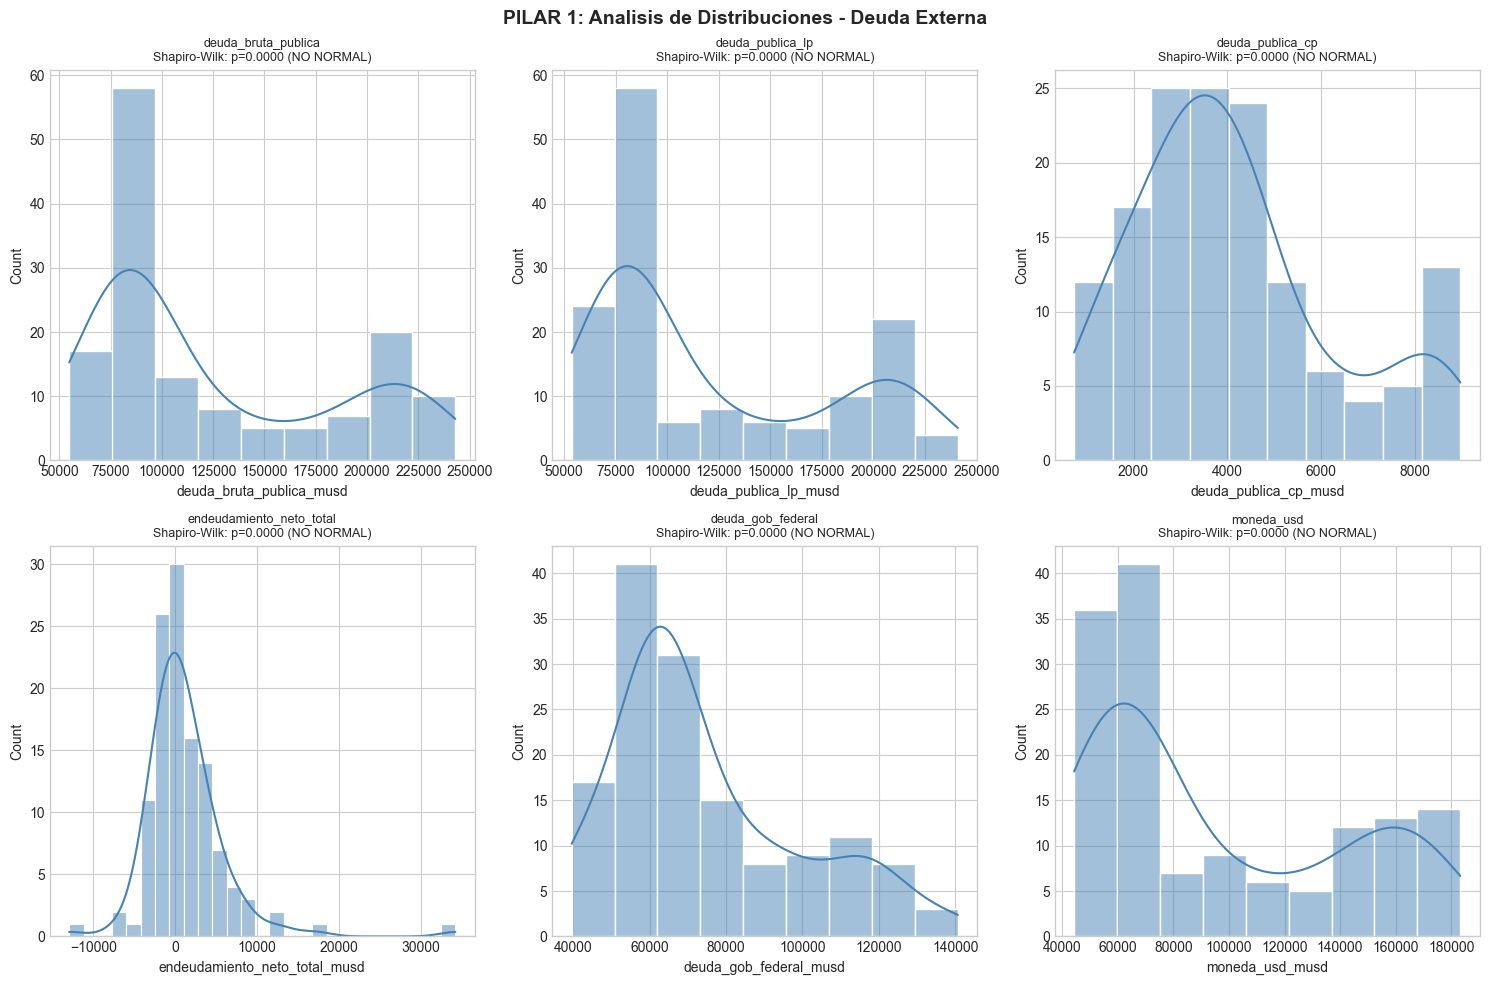


RESUMEN DE NORMALIDAD
deuda_bruta_publica_musd: p=0.0000 | Sesgo=0.75 | Curtosis=-1.03 | No Normal
deuda_publica_lp_musd: p=0.0000 | Sesgo=0.74 | Curtosis=-1.07 | No Normal
deuda_publica_cp_musd: p=0.0000 | Sesgo=0.72 | Curtosis=-0.19 | No Normal
endeudamiento_neto_total_musd: p=0.0000 | Sesgo=2.75 | Curtosis=16.19 | No Normal
deuda_gob_federal_musd: p=0.0000 | Sesgo=0.90 | Curtosis=0.01 | No Normal
moneda_usd_musd: p=0.0000 | Sesgo=0.61 | Curtosis=-1.21 | No Normal


In [5]:
# ============================================================================
# PILAR 1: DISTRIBUCIONES
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('PILAR 1: Analisis de Distribuciones - Deuda Externa', fontsize=14, fontweight='bold')

# Variables clave para analizar
vars_analizar = ['deuda_bruta_publica_musd', 'deuda_publica_lp_musd', 'deuda_publica_cp_musd',
                 'endeudamiento_neto_total_musd', 'deuda_gob_federal_musd', 'moneda_usd_musd']

for idx, var in enumerate(vars_analizar):
    ax = axes[idx // 3, idx % 3]
    if var in df_procesado.columns:
        data = df_procesado[var].dropna()
        
        # Histograma con KDE
        sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
        
        # Test de normalidad (Shapiro-Wilk para n<5000, D'Agostino para n>=5000)
        if len(data) >= 20:
            if len(data) < 5000:
                stat, p_value = shapiro(data)
                test_name = 'Shapiro-Wilk'
            else:
                stat, p_value = normaltest(data)
                test_name = "D'Agostino"
            
            normalidad = 'NORMAL' if p_value > 0.05 else 'NO NORMAL'
            ax.set_title(f'{var.replace("_musd", "")}\n{test_name}: p={p_value:.4f} ({normalidad})', fontsize=9)
        else:
            ax.set_title(f'{var.replace("_musd", "")}\n(datos insuficientes)', fontsize=9)
    else:
        ax.set_title(f'{var}\n(no disponible)', fontsize=9)
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Resumen de normalidad
print("\n" + "="*60)
print("RESUMEN DE NORMALIDAD")
print("="*60)
for var in vars_analizar:
    if var in df_procesado.columns:
        data = df_procesado[var].dropna()
        if len(data) >= 20:
            stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
            skew = data.skew()
            kurt = data.kurtosis()
            print(f"{var}: p={p:.4f} | Sesgo={skew:.2f} | Curtosis={kurt:.2f} | {'Normal' if p>0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad - ¿Donde esta el comportamiento tipico?

**Objetivo:** Identificar Media, Mediana y Moda de las variables principales.

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
                 Variable         Media   Mediana     Moda  Diferencia Media-Mediana (%)
     deuda_total_economia 198164.628169 156452.65  94188.7                     26.661088
      deuda_bruta_publica 124674.751469  93931.30  54766.3                     32.729720
       activos_fx_publico   7169.153559   5952.00      0.0                     20.449489
    posicion_neta_publico 117505.616790  84405.70  21356.8                     39.215262
         deuda_publica_lp 120570.126294  89911.30  53702.6                     34.098969
         deuda_publica_cp   4104.639161   3714.40   2789.5                     10.506116
        deuda_gob_federal  74534.943776  66910.40  39633.4                     11.395155
deuda_organismos_empresas  41357.544056  13739.20      0.0                    201.018575
   deuda_banca_desarrollo   8341.523077   8296.90      0.0                      0.537828
 endeudamiento_neto_total   1188.166303    443.70 -12932.2              

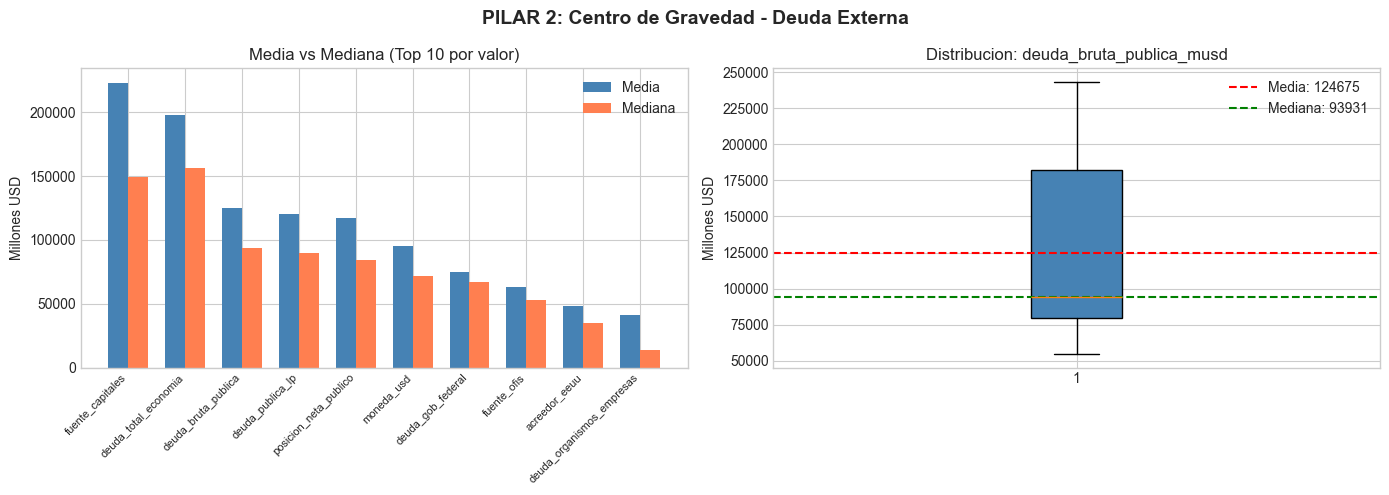

In [6]:
# ============================================================================
# PILAR 2: CENTRO DE GRAVEDAD
# ============================================================================

print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

# Calcular estadisticas para todas las variables
stats_centro = []
for var in cols_numericas:
    data = df_procesado[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var.replace('_musd', ''),
            'Media': data.mean(),
            'Mediana': data.median(),
            'Moda': data.mode().iloc[0] if len(data.mode()) > 0 else np.nan,
            'Diferencia Media-Mediana (%)': ((data.mean() - data.median()) / data.median() * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad - Deuda Externa', fontsize=14, fontweight='bold')

# Grafico 1: Comparacion Media vs Mediana (top 10 variables)
top_vars = df_centro.nlargest(10, 'Media')
x = np.arange(len(top_vars))
width = 0.35
axes[0].bar(x - width/2, top_vars['Media'], width, label='Media', color='steelblue')
axes[0].bar(x + width/2, top_vars['Mediana'], width, label='Mediana', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_vars['Variable'], rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('Millones USD')
axes[0].set_title('Media vs Mediana (Top 10 por valor)')
axes[0].legend()

# Grafico 2: Boxplot de variable principal
data_principal = df_procesado[VAR_PRINCIPAL].dropna()
bp = axes[1].boxplot(data_principal, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].axhline(data_principal.mean(), color='red', linestyle='--', label=f'Media: {data_principal.mean():.0f}')
axes[1].axhline(data_principal.median(), color='green', linestyle='--', label=f'Mediana: {data_principal.median():.0f}')
axes[1].set_ylabel('Millones USD')
axes[1].set_title(f'Distribucion: {VAR_PRINCIPAL}')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad - ¿Que tan confiables son los datos?

**Objetivo:** Medir riesgo, volatilidad y detectar anomalias.

PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD
                 Variable     Desv. Std       CV (%)    Rango        IQR  Outliers  % Outliers
     deuda_total_economia  83473.144457    42.123130 258211.4 161675.975         0    0.000000
      deuda_bruta_publica  58197.776746    46.679681 188341.6 102411.200         0    0.000000
       activos_fx_publico   5581.417962    77.853235  34565.9   5872.150         6    4.195804
    posicion_neta_publico  61029.752436    51.937732 216852.9 107200.400         0    0.000000
         deuda_publica_lp  56897.627727    47.190485 187186.8 102164.750         0    0.000000
         deuda_publica_cp   2124.581253    51.760488   8223.5   2253.000         9    6.293706
        deuda_gob_federal  24581.963858    32.980455 101012.3  29723.100         3    2.097902
deuda_organismos_empresas  35848.807574    86.680214 104189.2  71892.550         0    0.000000
   deuda_banca_desarrollo   2111.615390    25.314506  14008.6   2523.900         4    2.797203
 endeu

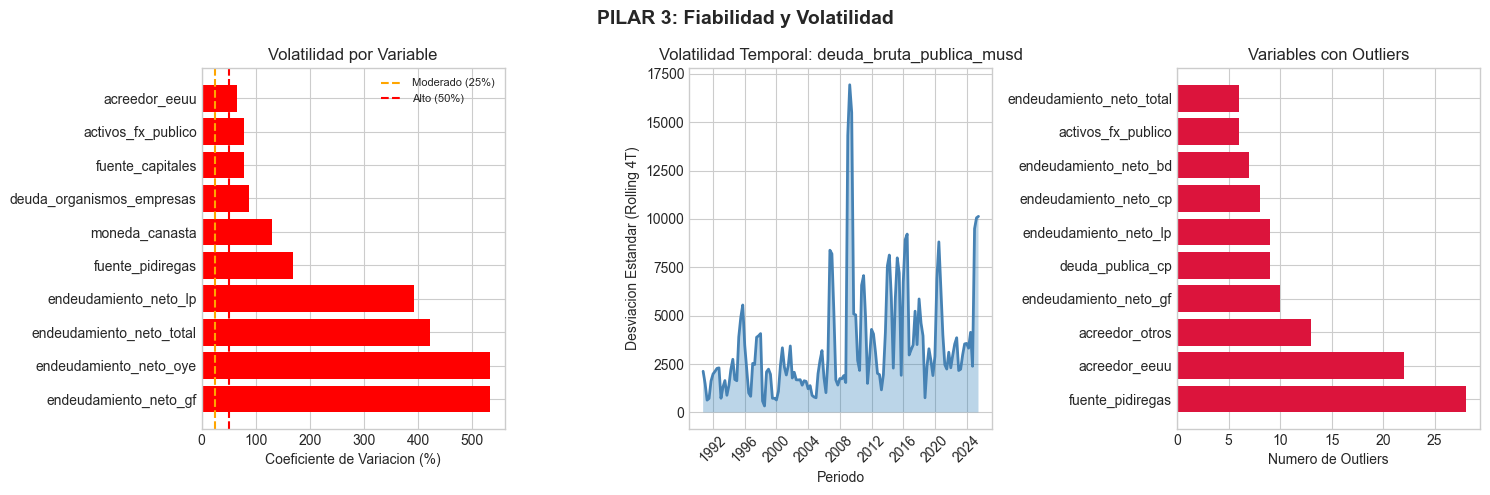

In [7]:
# ============================================================================
# PILAR 3: FIABILIDAD - RIESGO Y VOLATILIDAD
# ============================================================================

print("PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD")
print("="*80)

# Calcular metricas de fiabilidad
stats_fiabilidad = []
for var in cols_numericas:
    data = df_procesado[var].dropna()
    if len(data) > 0:
        # Coeficiente de variacion (CV)
        cv = (data.std() / data.mean() * 100) if data.mean() != 0 else np.nan
        
        # Deteccion de outliers (IQR)
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        stats_fiabilidad.append({
            'Variable': var.replace('_musd', ''),
            'Desv. Std': data.std(),
            'CV (%)': cv,
            'Rango': data.max() - data.min(),
            'IQR': IQR,
            'Outliers': outliers,
            '% Outliers': outliers / len(data) * 100
        })

df_fiabilidad = pd.DataFrame(stats_fiabilidad)
print(df_fiabilidad.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('PILAR 3: Fiabilidad y Volatilidad', fontsize=14, fontweight='bold')

# Grafico 1: Coeficiente de Variacion
cv_data = df_fiabilidad.nlargest(10, 'CV (%)')
colors = ['red' if cv > 50 else 'orange' if cv > 25 else 'green' for cv in cv_data['CV (%)']]
axes[0].barh(cv_data['Variable'], cv_data['CV (%)'], color=colors)
axes[0].axvline(25, color='orange', linestyle='--', label='Moderado (25%)')
axes[0].axvline(50, color='red', linestyle='--', label='Alto (50%)')
axes[0].set_xlabel('Coeficiente de Variacion (%)')
axes[0].set_title('Volatilidad por Variable')
axes[0].legend(fontsize=8)

# Grafico 2: Evolucion temporal de volatilidad (rolling std)
if VAR_PRINCIPAL in df_procesado.columns:
    rolling_std = df_procesado[VAR_PRINCIPAL].rolling(window=4).std()
    axes[1].plot(df_procesado['periodo'], rolling_std, color='steelblue', linewidth=2)
    axes[1].fill_between(df_procesado['periodo'], rolling_std, alpha=0.3)
    axes[1].set_xlabel('Periodo')
    axes[1].set_ylabel('Desviacion Estandar (Rolling 4T)')
    axes[1].set_title(f'Volatilidad Temporal: {VAR_PRINCIPAL}')
    axes[1].tick_params(axis='x', rotation=45)

# Grafico 3: Deteccion de outliers
outlier_vars = df_fiabilidad[df_fiabilidad['Outliers'] > 0].nlargest(10, 'Outliers')
if len(outlier_vars) > 0:
    axes[2].barh(outlier_vars['Variable'], outlier_vars['Outliers'], color='crimson')
    axes[2].set_xlabel('Numero de Outliers')
    axes[2].set_title('Variables con Outliers')
else:
    axes[2].text(0.5, 0.5, 'Sin outliers detectados', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Variables con Outliers')

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error - Intervalos de Confianza

**Objetivo:** Proporcionar rangos probables con certeza estadistica.

PILAR 4: INTERVALOS DE CONFIANZA (95%)
                 Variable         Media  IC 95% Inferior  IC 95% Superior  Margen de Error  Margen (%)
     deuda_total_economia 198164.628169    184316.399681    212012.856657     13848.228488    6.988244
      deuda_bruta_publica 124674.751469    115054.121232    134295.381705      9620.630236    7.716583
       activos_fx_publico   7169.153559      6246.493599      8091.813520       922.659961   12.869859
    posicion_neta_publico 117505.616790    107416.834806    127594.398775     10088.781985    8.585787
         deuda_publica_lp 120570.126294    111164.422704    129975.829884      9405.703590    7.801023
         deuda_publica_cp   4104.639161      3753.426249      4455.852073       351.212912    8.556487
        deuda_gob_federal  74534.943776     70471.318016     78598.569536      4063.625760    5.451974
deuda_organismos_empresas  41357.544056     35431.404926     47283.683186      5926.139130   14.329040
   deuda_banca_desarrollo   8341.5

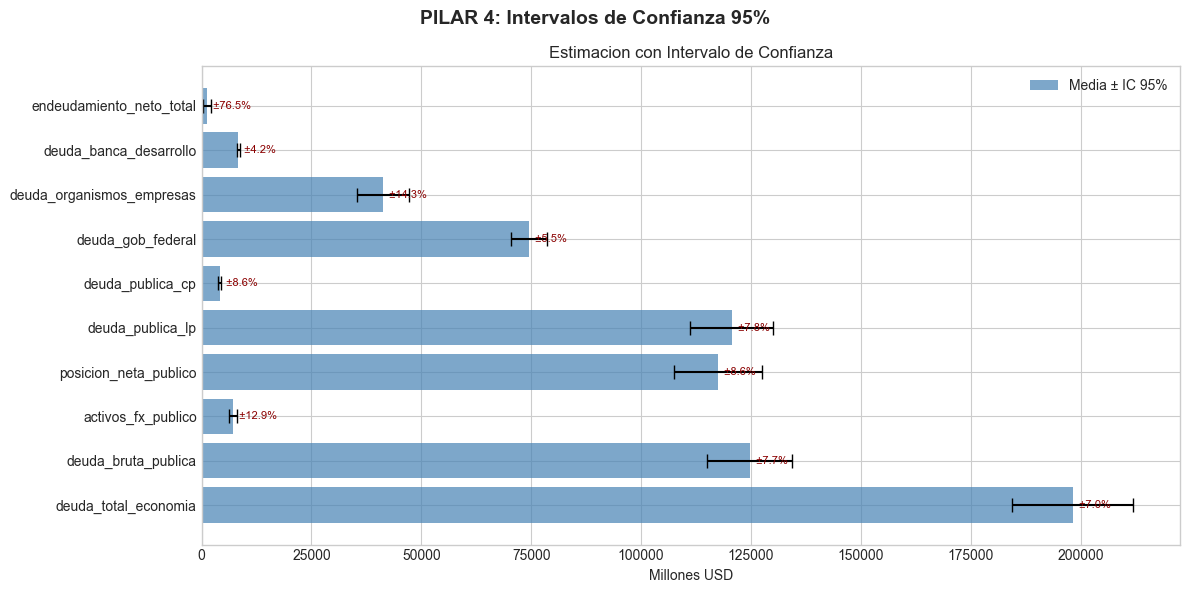

In [8]:
# ============================================================================
# PILAR 4: MARGEN DE ERROR - INTERVALOS DE CONFIANZA
# ============================================================================

print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    """Calcula intervalo de confianza para la media."""
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)  # Error estandar de la media
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

# Calcular IC para variables principales
ic_results = []
for var in cols_numericas[:10]:  # Top 10 variables
    data = df_procesado[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var.replace('_musd', ''),
            'Media': data.mean(),
            'IC 95% Inferior': ic_low,
            'IC 95% Superior': ic_high,
            'Margen de Error': margen,
            'Margen (%)': (margen / data.mean() * 100) if data.mean() != 0 else 0
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

# Visualizacion
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('PILAR 4: Intervalos de Confianza 95%', fontsize=14, fontweight='bold')

y_pos = np.arange(len(df_ic))
ax.barh(y_pos, df_ic['Media'], xerr=df_ic['Margen de Error'], 
        color='steelblue', alpha=0.7, capsize=5, label='Media ± IC 95%')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_ic['Variable'])
ax.set_xlabel('Millones USD')
ax.set_title('Estimacion con Intervalo de Confianza')
ax.legend()

# Agregar valores
for i, (media, margen) in enumerate(zip(df_ic['Media'], df_ic['Margen (%)'])):
    ax.text(media, i, f'  ±{margen:.1f}%', va='center', fontsize=8, color='darkred')

plt.tight_layout()
plt.show()

---
## PILAR 5: Pruebas de Hipotesis - ¿Fue suerte o fue real?

**Objetivo:** Validar afirmaciones con evidencia estadistica usando Chi-Cuadrada.

In [9]:
# ============================================================================
# PILAR 5: PRUEBAS DE HIPOTESIS - CHI-CUADRADA
# ============================================================================

print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: ¿La deuda de largo plazo es independiente del trimestre?
print("\n--- HIPOTESIS 1: Independencia Deuda LP vs Trimestre ---")
print("H0: La deuda de largo plazo es independiente del trimestre")
print("H1: La deuda de largo plazo depende del trimestre")

# Crear categorias para Chi-cuadrada
df_test = df_procesado.copy()
df_test['deuda_lp_cat'] = pd.qcut(df_test['deuda_publica_lp_musd'].dropna(), q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

# Tabla de contingencia
contingencia = pd.crosstab(df_test['deuda_lp_cat'], df_test['TRIMESTRE'])
print("\nTabla de Contingencia:")
print(contingencia)

# Test Chi-cuadrada
chi2, p_value, dof, expected = chi2_contingency(contingencia)
print(f"\nEstadistico Chi-cuadrada: {chi2:.4f}")
print(f"Grados de libertad: {dof}")
print(f"p-value: {p_value:.4f}")
print(f"\nConclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
if p_value < 0.05:
    print("-> Existe dependencia significativa entre deuda LP y trimestre")
else:
    print("-> No hay evidencia de dependencia entre deuda LP y trimestre")

PILAR 5: PRUEBAS DE HIPOTESIS

--- HIPOTESIS 1: Independencia Deuda LP vs Trimestre ---
H0: La deuda de largo plazo es independiente del trimestre
H1: La deuda de largo plazo depende del trimestre

Tabla de Contingencia:
TRIMESTRE      1   2   3   4
deuda_lp_cat                
Bajo           8  10  10   8
Medio-Bajo    11   8   8   9
Medio-Alto     8   9   8  10
Alto           9   9  10   8

Estadistico Chi-cuadrada: 1.6263
Grados de libertad: 9
p-value: 0.9961

Conclusion: NO RECHAZAR H0 (alfa=0.05)
-> No hay evidencia de dependencia entre deuda LP y trimestre


In [10]:
# Hipotesis 2: ¿La composicion de la deuda cambio antes/despues de 2015?
print("\n--- HIPOTESIS 2: Cambio estructural 2015 ---")
print("H0: La composicion LP/CP es independiente del periodo (pre/post 2015)")
print("H1: La composicion LP/CP depende del periodo")

df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2015' if x.year < 2015 else 'Post-2015')
df_test['ratio_lp_cp'] = df_test['deuda_publica_lp_musd'] / df_test['deuda_publica_cp_musd'].replace(0, np.nan)
df_test['ratio_cat'] = pd.qcut(df_test['ratio_lp_cp'].dropna(), q=3, labels=['Bajo', 'Medio', 'Alto'])

# Tabla de contingencia
contingencia2 = pd.crosstab(df_test['ratio_cat'].dropna(), df_test.loc[df_test['ratio_cat'].notna(), 'era'])
print("\nTabla de Contingencia (Ratio LP/CP vs Era):")
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingencia2)
    print(f"\nEstadistico Chi-cuadrada: {chi2_2:.4f}")
    print(f"p-value: {p_value_2:.4f}")
    print(f"\nConclusion: {'RECHAZAR H0' if p_value_2 < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    print("Datos insuficientes para el test")


--- HIPOTESIS 2: Cambio estructural 2015 ---
H0: La composicion LP/CP es independiente del periodo (pre/post 2015)
H1: La composicion LP/CP depende del periodo

Tabla de Contingencia (Ratio LP/CP vs Era):
era        Post-2015  Pre-2015
ratio_cat                     
Bajo               0        48
Medio             25        22
Alto              18        30

Estadistico Chi-cuadrada: 33.8493
p-value: 0.0000

Conclusion: RECHAZAR H0 (alfa=0.05)


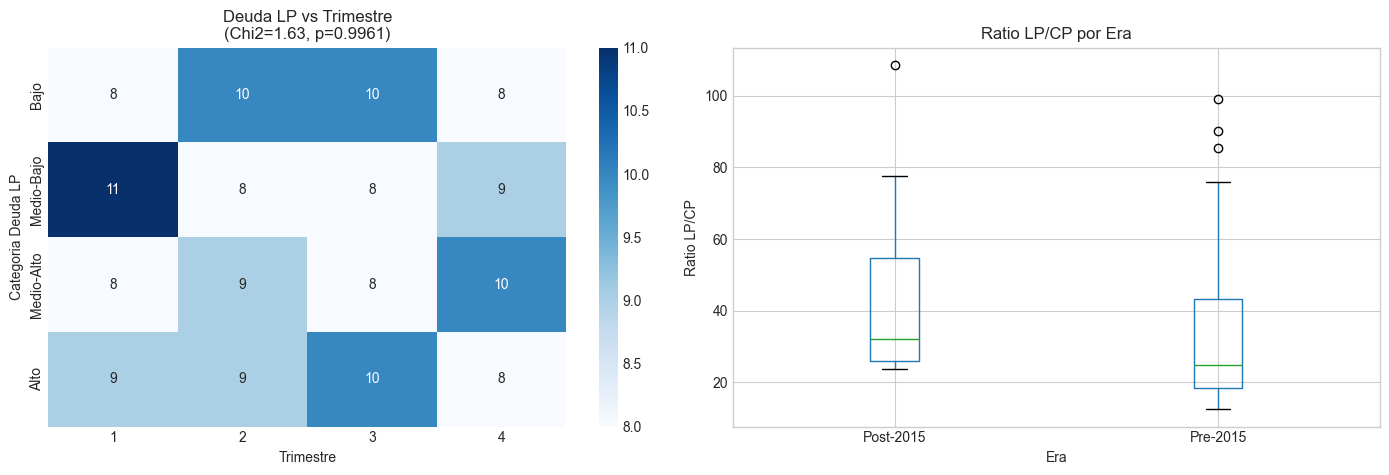

In [11]:
# Visualizacion de pruebas de hipotesis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Pruebas de Hipotesis - Chi-Cuadrada', fontsize=14, fontweight='bold')

# Grafico 1: Heatmap de contingencia 1
sns.heatmap(contingencia, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Deuda LP vs Trimestre\n(Chi2={chi2:.2f}, p={p_value:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Categoria Deuda LP')

# Grafico 2: Distribucion por era
df_test.boxplot(column='ratio_lp_cp', by='era', ax=axes[1])
axes[1].set_title('Ratio LP/CP por Era')
axes[1].set_xlabel('Era')
axes[1].set_ylabel('Ratio LP/CP')
plt.suptitle('')  # Quitar titulo automatico de boxplot

plt.tight_layout()
plt.show()

---
## PILAR 6: Regresion/Prediccion - ¿Como predecir el futuro?

**Objetivo:** Modelar relaciones para anticipar resultados usando Machine Learning.

In [12]:
# ============================================================================
# PILAR 6: PREDICCION CON MACHINE LEARNING
# ============================================================================

print("PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING")
print("="*80)

# Preparar datos para prediccion
# Objetivo: Predecir deuda bruta publica usando otras variables

# Features disponibles
features = ['deuda_publica_lp_musd', 'deuda_publica_cp_musd', 'deuda_gob_federal_musd',
            'deuda_organismos_empresas_musd', 'moneda_usd_musd', 'TRIMESTRE']
target = 'deuda_bruta_publica_musd'

# Filtrar columnas disponibles
features_disponibles = [f for f in features if f in df_procesado.columns]
print(f"Features para modelo: {features_disponibles}")
print(f"Target: {target}")

# Preparar dataset
df_ml = df_procesado[features_disponibles + [target]].dropna()
X = df_ml[features_disponibles]
y = df_ml[target]

print(f"\nDatos para entrenamiento: {len(df_ml)} observaciones")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING
Features para modelo: ['deuda_publica_lp_musd', 'deuda_publica_cp_musd', 'deuda_gob_federal_musd', 'deuda_organismos_empresas_musd', 'moneda_usd_musd', 'TRIMESTRE']
Target: deuda_bruta_publica_musd

Datos para entrenamiento: 143 observaciones


In [13]:
# Entrenar multiples modelos
modelos = {
    'Regresion Lineal': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

resultados = []
predicciones = {}

for nombre, modelo in modelos.items():
    # Entrenar
    if 'Forest' in nombre or 'Boosting' in nombre:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    else:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    
    # Metricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE (%)': (mae / y_test.mean() * 100)
    })
    predicciones[nombre] = y_pred

df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
print("\nCOMPARACION DE MODELOS:")
print(df_resultados.to_string(index=False))

# Mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']
print(f"\n*** MEJOR MODELO: {mejor_modelo} (R2 = {df_resultados.iloc[0]['R2']:.4f}) ***")


COMPARACION DE MODELOS:
           Modelo        RMSE         MAE       R2  MAPE (%)
 Regresion Lineal    0.121218    0.058004 1.000000  0.000049
            Ridge 1696.407863 1418.601502 0.999112  1.200211
Gradient Boosting 1923.345509 1396.767156 0.998859  1.181738
    Random Forest 2295.847065 1676.479414 0.998374  1.418389

*** MEJOR MODELO: Regresion Lineal (R2 = 1.0000) ***


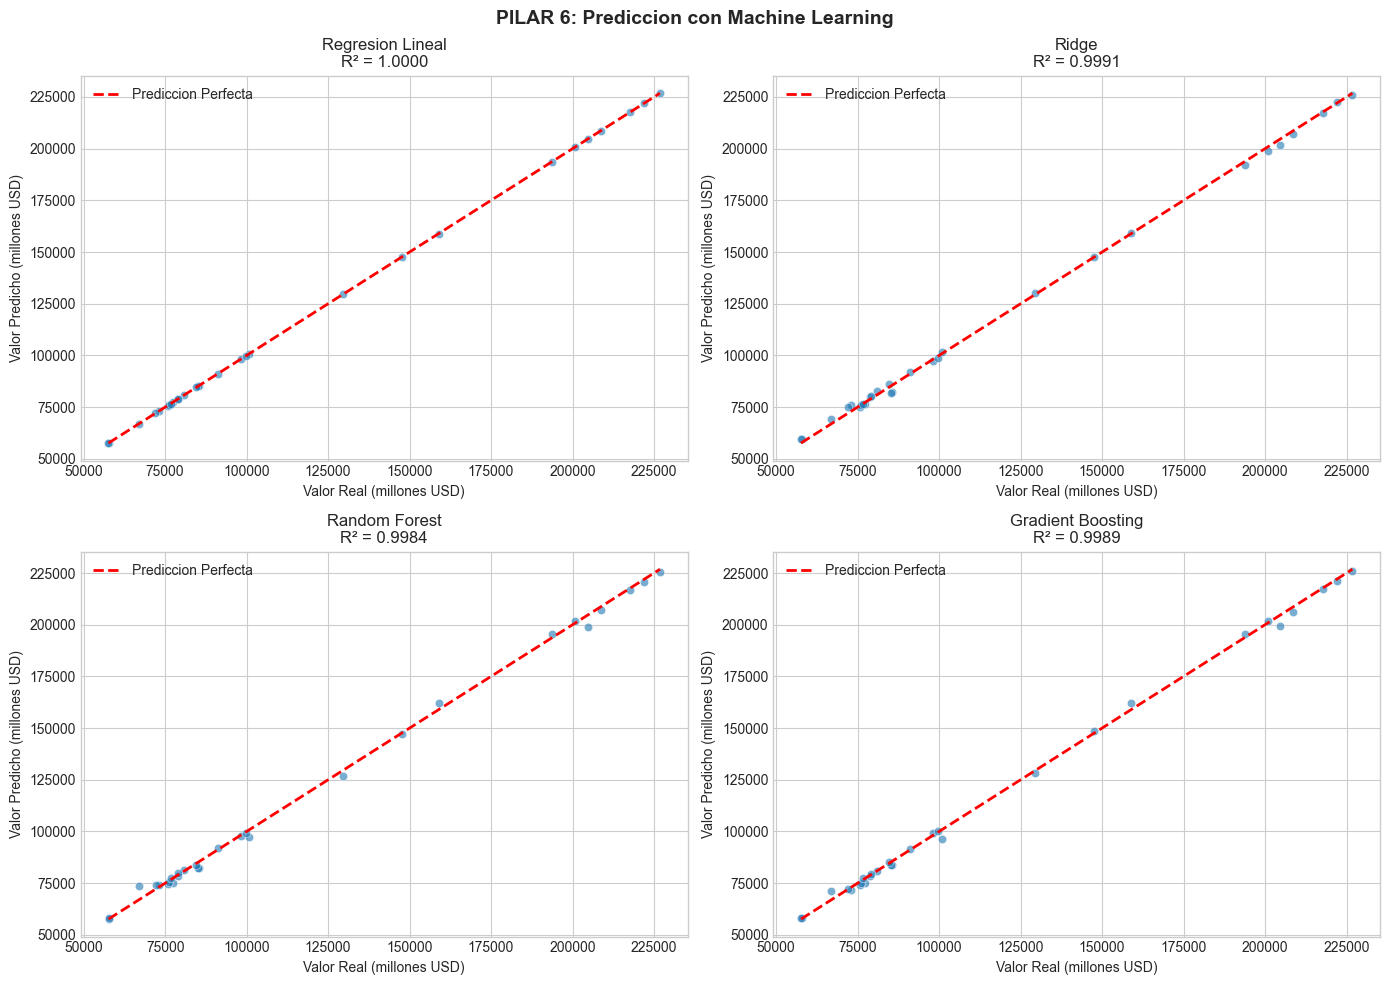

In [14]:
# Visualizacion de predicciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 6: Prediccion con Machine Learning', fontsize=14, fontweight='bold')

for idx, (nombre, y_pred) in enumerate(predicciones.items()):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='white', linewidth=0.5)
    
    # Linea de referencia perfecta
    min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediccion Perfecta')
    
    # Metricas
    r2 = r2_score(y_test, y_pred)
    ax.set_xlabel('Valor Real (millones USD)')
    ax.set_ylabel('Valor Predicho (millones USD)')
    ax.set_title(f'{nombre}\nR² = {r2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


IMPORTANCIA DE VARIABLES (Random Forest):
                       Feature  Importancia
         deuda_publica_lp_musd     0.368429
        deuda_gob_federal_musd     0.306909
deuda_organismos_empresas_musd     0.194394
               moneda_usd_musd     0.128837
         deuda_publica_cp_musd     0.001297
                     TRIMESTRE     0.000135


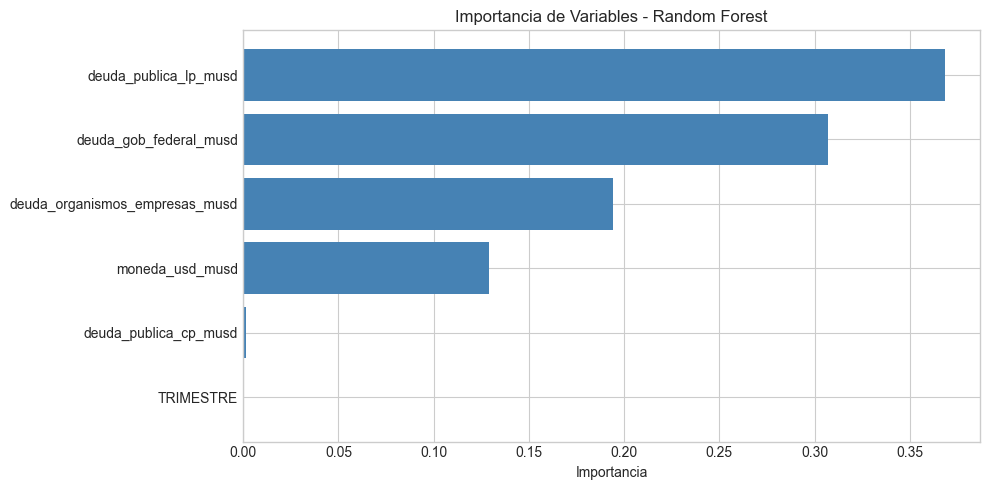

In [15]:
# Importancia de features (Random Forest)
rf_model = modelos['Random Forest']
importancia = pd.DataFrame({
    'Feature': features_disponibles,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nIMPORTANCIA DE VARIABLES (Random Forest):")
print(importancia.to_string(index=False))

# Grafico de importancia
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(importancia['Feature'], importancia['Importancia'], color='steelblue')
ax.set_xlabel('Importancia')
ax.set_title('Importancia de Variables - Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## PILAR 7: Series de Tiempo - ¿Que patrones se repiten?

**Objetivo:** Detectar tendencias y estacionalidad para pronosticos precisos.

In [16]:
# ============================================================================
# PILAR 7: SERIES DE TIEMPO
# ============================================================================

print("PILAR 7: ANALISIS DE SERIES DE TIEMPO")
print("="*80)

# Preparar serie temporal
ts_data = df_procesado.set_index('periodo')[VAR_PRINCIPAL].dropna()
ts_data = ts_data.asfreq('QS')  # Frecuencia trimestral

print(f"Serie temporal: {VAR_PRINCIPAL}")
print(f"Periodo: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

# Test de estacionariedad (Dickey-Fuller)
adf_result = adfuller(ts_data.dropna())
print(f"\nTest Dickey-Fuller Aumentado:")
print(f"  Estadistico ADF: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Valores criticos:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")
print(f"\n  Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'} (alfa=0.05)")

PILAR 7: ANALISIS DE SERIES DE TIEMPO
Serie temporal: deuda_bruta_publica_musd
Periodo: 1990-01-01 00:00:00 a 2025-07-01 00:00:00
Observaciones: 143

Test Dickey-Fuller Aumentado:
  Estadistico ADF: 0.5140
  p-value: 0.9853
  Valores criticos:
    1%: -3.4786
    5%: -2.8827
    10%: -2.5781

  Conclusion: NO ESTACIONARIA (alfa=0.05)


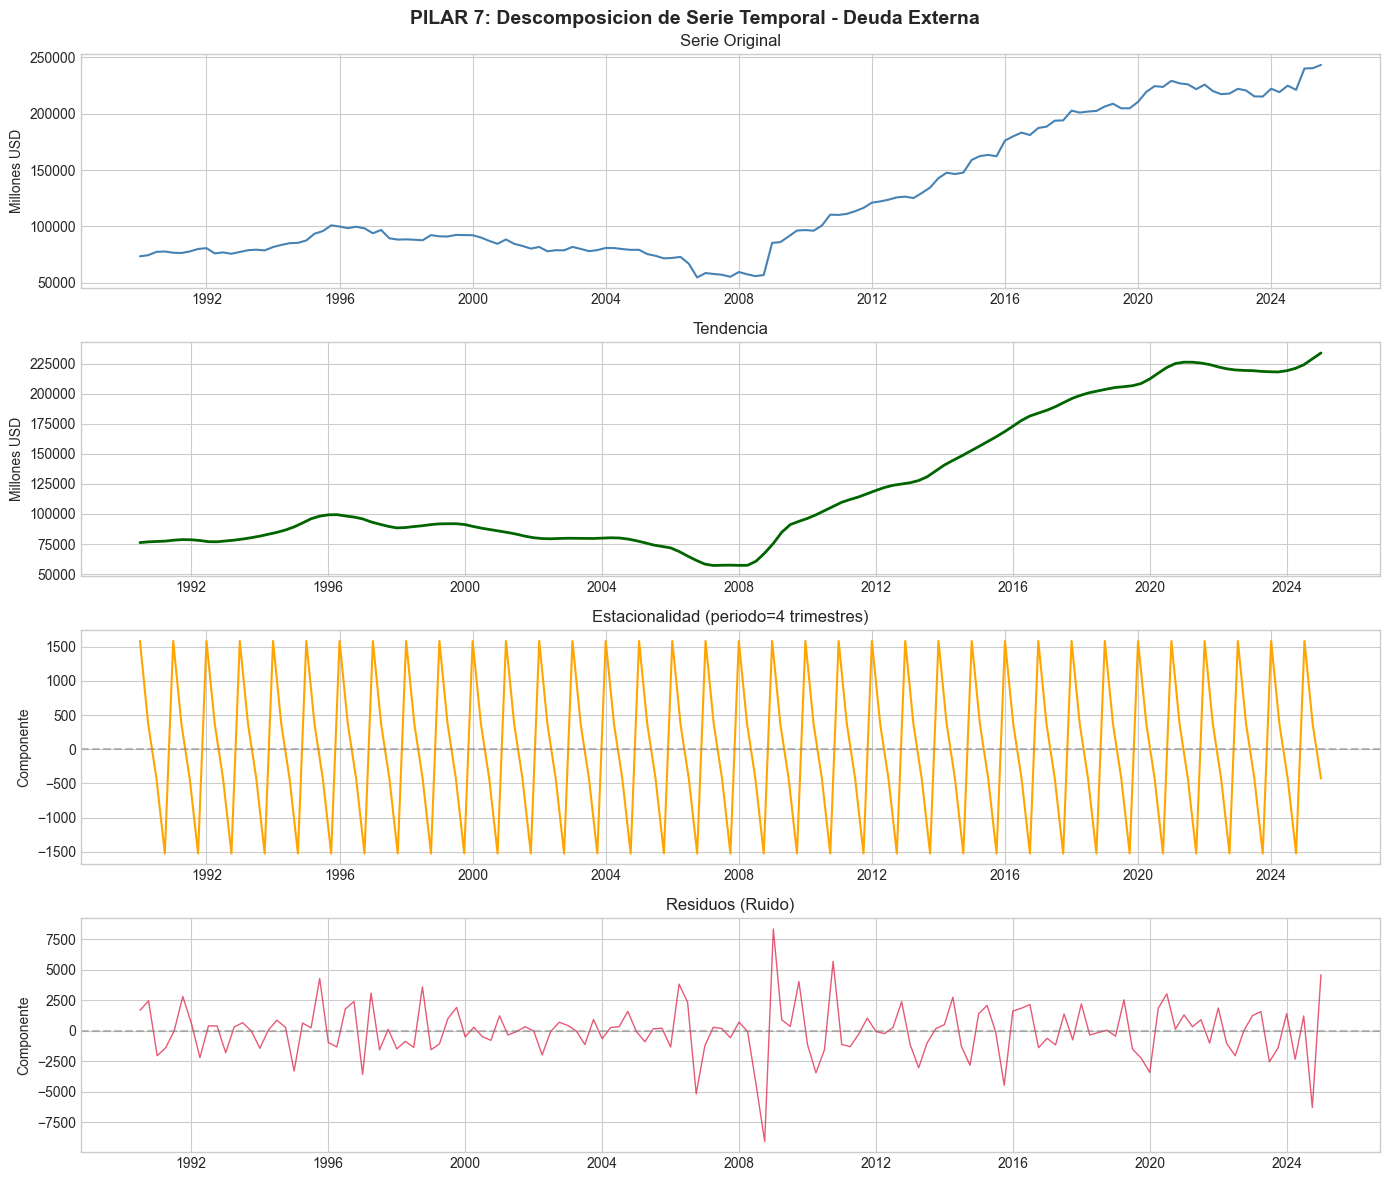


ESTADISTICAS DE COMPONENTES:
  Tendencia - Cambio total: 157603.11 millones USD
  Estacionalidad - Amplitud: 3108.56 millones USD
  Residuos - Desv. Std: 2166.12 millones USD


In [17]:
# Descomposicion de la serie
if len(ts_data.dropna()) >= 8:  # Minimo para descomposicion
    decomposition = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion de Serie Temporal - Deuda Externa', fontsize=14, fontweight='bold')
    
    # Original
    axes[0].plot(ts_data, color='steelblue', linewidth=1.5)
    axes[0].set_title('Serie Original')
    axes[0].set_ylabel('Millones USD')
    
    # Tendencia
    axes[1].plot(decomposition.trend, color='darkgreen', linewidth=2)
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Millones USD')
    
    # Estacionalidad
    axes[2].plot(decomposition.seasonal, color='orange', linewidth=1.5)
    axes[2].set_title('Estacionalidad (periodo=4 trimestres)')
    axes[2].set_ylabel('Componente')
    axes[2].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Residuos
    axes[3].plot(decomposition.resid, color='crimson', linewidth=1, alpha=0.7)
    axes[3].set_title('Residuos (Ruido)')
    axes[3].set_ylabel('Componente')
    axes[3].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Estadisticas de componentes
    print("\nESTADISTICAS DE COMPONENTES:")
    print(f"  Tendencia - Cambio total: {decomposition.trend.dropna().iloc[-1] - decomposition.trend.dropna().iloc[0]:.2f} millones USD")
    print(f"  Estacionalidad - Amplitud: {decomposition.seasonal.max() - decomposition.seasonal.min():.2f} millones USD")
    print(f"  Residuos - Desv. Std: {decomposition.resid.std():.2f} millones USD")
else:
    print("Datos insuficientes para descomposicion (minimo 8 observaciones)")

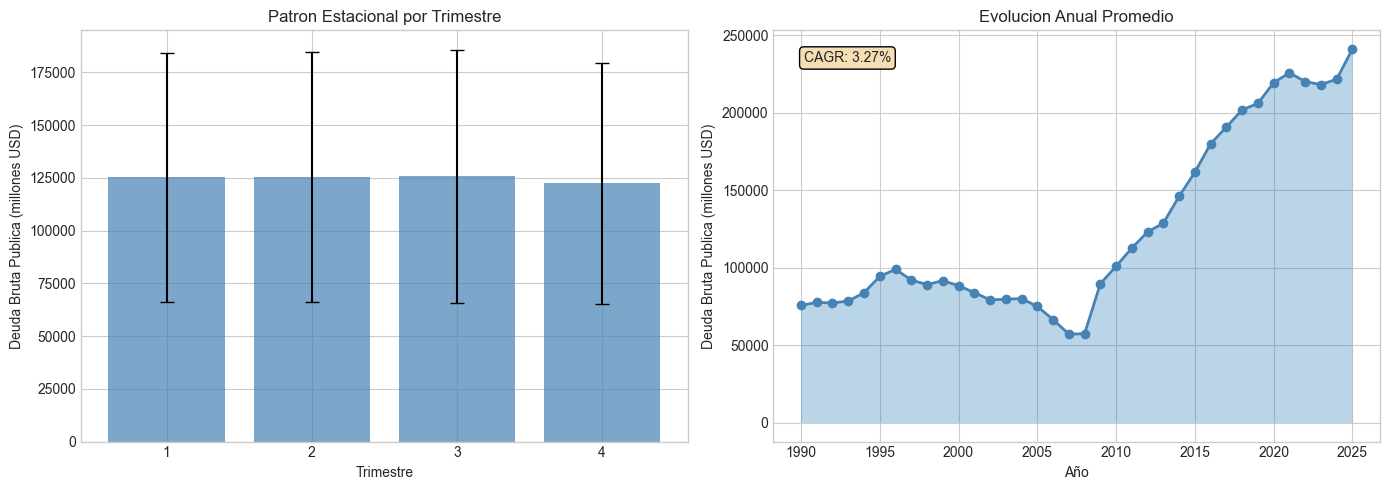

In [18]:
# Patron estacional por trimestre
df_procesado['year'] = df_procesado['periodo'].dt.year
patron_trimestral = df_procesado.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patron por trimestre
axes[0].bar(patron_trimestral.index, patron_trimestral['mean'], 
            yerr=patron_trimestral['std'], capsize=5, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Deuda Bruta Publica (millones USD)')
axes[0].set_title('Patron Estacional por Trimestre')
axes[0].set_xticks([1, 2, 3, 4])

# Evolucion anual
evolucion_anual = df_procesado.groupby('year')[VAR_PRINCIPAL].mean()
axes[1].plot(evolucion_anual.index, evolucion_anual.values, marker='o', linewidth=2, color='steelblue')
axes[1].fill_between(evolucion_anual.index, evolucion_anual.values, alpha=0.3)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Deuda Bruta Publica (millones USD)')
axes[1].set_title('Evolucion Anual Promedio')

# Tasa de crecimiento
cagr = ((evolucion_anual.iloc[-1] / evolucion_anual.iloc[0]) ** (1 / len(evolucion_anual)) - 1) * 100
axes[1].text(0.05, 0.95, f'CAGR: {cagr:.2f}%', transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA - ¿Que estrategia es mejor?

**Objetivo:** Comparar rendimiento entre grupos objetivamente.

In [19]:
# ============================================================================
# PILAR 8: ANOVA - COMPARACION ENTRE GRUPOS
# ============================================================================

print("PILAR 8: ANALISIS DE VARIANZA (ANOVA)")
print("="*80)

# Analisis 1: Comparar deuda entre trimestres
print("\n--- ANOVA 1: Deuda Bruta por Trimestre ---")
print("H0: La deuda bruta es igual en todos los trimestres")
print("H1: Al menos un trimestre tiene deuda diferente")

grupos_trim = [df_procesado[df_procesado['TRIMESTRE'] == t][VAR_PRINCIPAL].dropna() for t in [1, 2, 3, 4]]

# ANOVA de una via (o Kruskal-Wallis si no es normal)
f_stat, p_anova = stats.f_oneway(*grupos_trim)
print(f"\nEstadistico F: {f_stat:.4f}")
print(f"p-value: {p_anova:.4f}")
print(f"Conclusion: {'RECHAZAR H0' if p_anova < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")

# Test no parametrico (Kruskal-Wallis) como alternativa
h_stat, p_kruskal = kruskal(*grupos_trim)
print(f"\nKruskal-Wallis (no parametrico):")
print(f"  Estadistico H: {h_stat:.4f}")
print(f"  p-value: {p_kruskal:.4f}")

PILAR 8: ANALISIS DE VARIANZA (ANOVA)

--- ANOVA 1: Deuda Bruta por Trimestre ---
H0: La deuda bruta es igual en todos los trimestres
H1: Al menos un trimestre tiene deuda diferente

Estadistico F: 0.0230
p-value: 0.9953
Conclusion: NO RECHAZAR H0 (alfa=0.05)

Kruskal-Wallis (no parametrico):
  Estadistico H: 0.1212
  p-value: 0.9892


In [20]:
# Analisis 2: Comparar periodos (decadas)
print("\n--- ANOVA 2: Deuda Bruta por Decada ---")

df_procesado['decada'] = (df_procesado['periodo'].dt.year // 10) * 10
decadas = df_procesado['decada'].unique()
grupos_decada = [df_procesado[df_procesado['decada'] == d][VAR_PRINCIPAL].dropna() for d in sorted(decadas)]
grupos_decada = [g for g in grupos_decada if len(g) >= 3]  # Minimo 3 observaciones

if len(grupos_decada) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_decada)
    print(f"\nEstadistico F: {f_stat2:.4f}")
    print(f"p-value: {p_anova2:.6f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova2 < 0.05 else 'NO RECHAZAR H0'}")
    if p_anova2 < 0.05:
        print("-> Existe diferencia significativa en la deuda entre decadas")
else:
    print("Datos insuficientes para comparar decadas")


--- ANOVA 2: Deuda Bruta por Decada ---

Estadistico F: 308.5809
p-value: 0.000000
Conclusion: RECHAZAR H0
-> Existe diferencia significativa en la deuda entre decadas


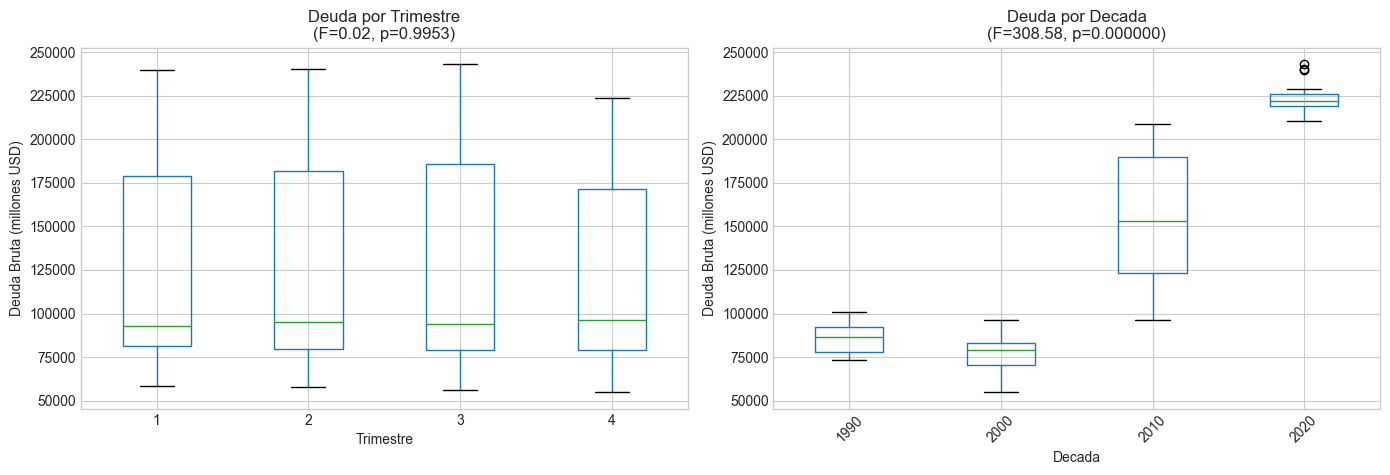

In [21]:
# Visualizacion ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA - Comparacion entre Grupos', fontsize=14, fontweight='bold')

# Grafico 1: Boxplot por trimestre
df_procesado.boxplot(column=VAR_PRINCIPAL, by='TRIMESTRE', ax=axes[0])
axes[0].set_title(f'Deuda por Trimestre\n(F={f_stat:.2f}, p={p_anova:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Deuda Bruta (millones USD)')
plt.suptitle('')

# Grafico 2: Boxplot por decada
df_procesado.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
if len(grupos_decada) >= 2:
    axes[1].set_title(f'Deuda por Decada\n(F={f_stat2:.2f}, p={p_anova2:.6f})')
else:
    axes[1].set_title('Deuda por Decada')
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('Deuda Bruta (millones USD)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

In [22]:
# Estadisticas descriptivas por grupo
print("\nESTADISTICAS POR TRIMESTRE:")
print(df_procesado.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max']).round(2))

print("\nESTADISTICAS POR DECADA:")
print(df_procesado.groupby('decada')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max']).round(2))


ESTADISTICAS POR TRIMESTRE:
           count       mean       std      min       max
TRIMESTRE                                               
1             36  125244.10  58966.88  58674.2  239987.9
2             36  125268.62  59314.89  57630.6  240253.4
3             36  125694.42  59849.97  55922.7  243107.9
4             35  122429.50  57010.12  54766.3  223648.6

ESTADISTICAS POR DECADA:
        count       mean       std       min       max
decada                                                
1990       40   86012.14   8357.76   73527.3  100933.7
2000       40   75819.42  11717.20   54766.3   96353.7
2010       40  155260.68  36955.32   96216.2  208710.0
2020       23  223686.94   8108.45  210399.9  243107.9


---
## RESUMEN EJECUTIVO

Sintesis de los hallazgos de los 8 pilares estadisticos.

In [23]:
# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print("="*80)
print("RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - DEUDA EXTERNA")
print("="*80)

print("\n1. DISTRIBUCIONES:")
print(f"   - La mayoria de variables NO siguen distribucion normal")
print(f"   - Se recomienda usar metodos no parametricos o transformaciones")

print("\n2. CENTRO DE GRAVEDAD:")
print(f"   - Deuda Bruta Publica: Media = {df_procesado[VAR_PRINCIPAL].mean():,.0f} millones USD")
print(f"   - Mediana = {df_procesado[VAR_PRINCIPAL].median():,.0f} millones USD")

print("\n3. FIABILIDAD:")
cv_principal = df_procesado[VAR_PRINCIPAL].std() / df_procesado[VAR_PRINCIPAL].mean() * 100
print(f"   - Coeficiente de Variacion: {cv_principal:.1f}%")
print(f"   - Datos {'ESTABLES' if cv_principal < 25 else 'VOLATILES'}")

print("\n4. MARGEN DE ERROR:")
ic_low, ic_high, margen = intervalo_confianza(df_procesado[VAR_PRINCIPAL].dropna())
print(f"   - IC 95%: [{ic_low:,.0f}, {ic_high:,.0f}] millones USD")
print(f"   - Margen: ±{margen/df_procesado[VAR_PRINCIPAL].mean()*100:.1f}%")

print("\n5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):")
print(f"   - Deuda LP vs Trimestre: {'Dependientes' if p_value < 0.05 else 'Independientes'} (p={p_value:.4f})")

print("\n6. PREDICCION (Machine Learning):")
print(f"   - Mejor modelo: {mejor_modelo}")
print(f"   - R² = {df_resultados.iloc[0]['R2']:.4f}")

print("\n7. SERIES DE TIEMPO:")
print(f"   - Serie {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
print(f"   - CAGR: {cagr:.2f}% anual")

print("\n8. ANOVA:")
print(f"   - Diferencia entre trimestres: {'SI' if p_anova < 0.05 else 'NO'} (p={p_anova:.4f})")
if len(grupos_decada) >= 2:
    print(f"   - Diferencia entre decadas: {'SI' if p_anova2 < 0.05 else 'NO'} (p={p_anova2:.6f})")

print("\n" + "="*80)
print("FIN DEL ANALISIS")
print("="*80)

RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - DEUDA EXTERNA

1. DISTRIBUCIONES:
   - La mayoria de variables NO siguen distribucion normal
   - Se recomienda usar metodos no parametricos o transformaciones

2. CENTRO DE GRAVEDAD:
   - Deuda Bruta Publica: Media = 124,675 millones USD
   - Mediana = 93,931 millones USD

3. FIABILIDAD:
   - Coeficiente de Variacion: 46.7%
   - Datos VOLATILES

4. MARGEN DE ERROR:
   - IC 95%: [115,054, 134,295] millones USD
   - Margen: ±7.7%

5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):
   - Deuda LP vs Trimestre: Independientes (p=0.9961)

6. PREDICCION (Machine Learning):
   - Mejor modelo: Regresion Lineal
   - R² = 1.0000

7. SERIES DE TIEMPO:
   - Serie NO ESTACIONARIA
   - CAGR: 3.27% anual

8. ANOVA:
   - Diferencia entre trimestres: NO (p=0.9953)
   - Diferencia entre decadas: SI (p=0.000000)

FIN DEL ANALISIS
